In [1]:
import sys
import numpy
import pandas
import sklearn

print(sys.version)
print('The numpy version is {}.'.format(numpy.__version__))
print('The pandas version is {}.'.format(pandas.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))

3.7.9 (default, Aug 31 2020, 07:22:35) 
[Clang 10.0.0 ]
The numpy version is 1.19.2.
The pandas version is 1.1.3.
The scikit-learn version is 0.23.2.


In [2]:
path = "/Users/phunp/Documents/Flinders/Thesis/data/real_data/extract_data_keep/"

import glob
import cv2
import os

setImgSize = set()

count = 0
distinctFileNames = set()
for fullFileName in glob.iglob(path + '**/*.jpg', recursive=True):
    baseName = os.path.basename(fullFileName)
    img = cv2.imread(fullFileName)
    
    setImgSize.add(img.shape)
    count += 1

print("there are total of %d files, size is %d" % (count, len(setImgSize)))
print(setImgSize)

there are total of 19236 files, size is 1
{(512, 640, 3)}


In [4]:
# 1001-1-L--2--2009-03-30T15-51-51__2.jpg
def extract_res_from_filename(file_name):
    return int(file_name[(len(file_name) - 29):(len(file_name) - 28)])

extract_res_from_filename("1001-1-L--2--2009-03-30T15-51-51__2.jpg")
fileff = "1001-1-L--2--2009-03-30T15-51-51__2.jpg"
print(fileff[(len(fileff) - 29):(len(fileff) - 28)])

2


In [25]:
flatten = False
categorical=True

import pickle
import numpy as np
import pandas as pd
import cv2
import glob
from PIL import Image
import os
import matplotlib.pyplot as plt

path = '/Users/phunp/Documents/Flinders/Thesis/data/real_data/extract_data_keep/'
read_path = '/Users/phunp/Documents/Flinders/Thesis/data/real_data/extract_data_crop_round/'

setSize = set()
# Original shape: 512x640x3
WIDTH = 160
HEIGHT = 160
SIZE = WIDTH * HEIGHT * 3
#IMAGE_COUNT = 11500 # for 5 labels
IMAGE_COUNT = 19200
# IMAGE_COUNT = 2
LABEL_CONVERTER = {"Normal": 1, "Healed": 2, "Inactive Muc": 3, "Inactive Squa": 4, "Active Muc": 5, "Active Squa": 6, "Fluid OME": 7, "Pus AOM": 8}
# LABEL_CONVERTER = {"Normal": 1, "Inactive Muc": 3, "Inactive Squa": 4, "Active Muc": 5, "Fluid OME": 7}
# CONVERT = {"1": 0, "3": 1, "4": 2, "5": 3, "7": 4}
CONVERT = {"1": 0, "2": 0, "3": 1, "4": 1, "5": 1, "6": 1, "7": 1, "8": 1}

# [[   1 2992]
#  [   2 7235]
#  [   3 2834]
#  [   4 1598]
#  [   5 2531]
#  [   6   16]
#  [   7 1794]]

indexes = {}

def load_images_from_folder(folder):
    X = np.empty((IMAGE_COUNT, SIZE)) # ==> FOR NORMAL
    # X = np.empty((IMAGE_COUNT, HEIGHT, WIDTH, 3))
    Y = np.empty([IMAGE_COUNT], dtype=int)
    i = 0
    for filename in os.listdir(folder):
        if not filename.endswith(".jpg"):
            continue
        label = extract_res_from_filename(filename)
        
        if label not in [1, 3, 4, 5, 7]:
            continue
        
        img = cv2.imread(os.path.join(read_path,filename))
        if img is not None:
            # resize image to a fix size TODO determine the best way to resize and preserve data
            img = cv2.resize(img, (WIDTH, HEIGHT), interpolation=cv2.INTER_AREA)
#             print("after initial resize, shape is: " + str(img.shape))
#             plt.imshow(img)
            flatten = img.reshape(-1) # ==> FOR NORMAL MODEL
#             print("after flatten, shape is: " + str(flatten.shape))
            # flatten = img # FOR MOBILEV2 NET
            # print('flatten size: ', flatten.shape)
            X[i] = flatten
#             reconstruct = flatten.reshape(160, 160, 3)
#             plt.imshow(reconstruct)
#             resize_again = flatten.reshape
            Y[i] = CONVERT[str(extract_res_from_filename(filename))]
            i = i+1
        if i >= IMAGE_COUNT:
            print("reading max of " + str(IMAGE_COUNT) + "... quit now")
            break;
        
    return X, Y


X, Y = load_images_from_folder(path)

print(X.shape)
print(Y.shape)


(19200, 76800)
(19200,)


In [6]:
print(X.shape)
print(Y.shape)
print(X[12])
print(Y[5000])
print(type(Y[17]))

(11500, 76800)
(11500,)
[21. 22. 28. ... 27. 27. 33.]
0
<class 'numpy.int64'>


In [26]:
# count frequency of all unique values in array
# https://www.kite.com/python/answers/how-to-count-frequency-of-unique-values-in-a-numpy-array-in-python#:~:text=Use%20numpy.,list%20of%20their%20corresponding%20frequencies.

(unique, counts) = numpy.unique(Y, return_counts=True)
frequencies = numpy.asarray((unique, counts)).T
print(frequencies)

[[    0 10324]
 [    1  8876]]


In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import classification_report
# ac
# X1 = X[0:400]
# y1 = y[0:400]
X1 = X
y1 = Y

# split into train and test
# Xtrain, Xtest, ytrain, ytest = train_test_split(X, y,stratify=y)
Xtrain, Xtest, ytrain, ytest = train_test_split(X1, y1,test_size=0.3, random_state=42, stratify=y1)

# normalise features
input_std = StandardScaler()
input_std.fit(Xtrain)
Xtrain_std = input_std.transform(Xtrain)
Xtest_std = input_std.transform(Xtest)

# do the PCA, choose the numbher of components to retain
input_pca = PCA(n_components=100, whiten=True)
input_pca.fit(Xtrain_std)
Xtrain_std_pca = input_pca.transform(Xtrain_std)
Xtest_std_pca = input_pca.transform(Xtest_std)

C = 10 ## Change this C value
model = SVC(kernel='rbf', C=C)
model.fit(Xtrain_std_pca, ytrain)

y_pred = model.predict(Xtrain_std_pca)
report = classification_report(ytrain, y_pred)
print(report)

y_pred = model.predict(Xtest_std_pca)
report = classification_report(ytest, y_pred)
print(report)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6930
           1       1.00      1.00      1.00      5934

    accuracy                           1.00     12864
   macro avg       1.00      1.00      1.00     12864
weighted avg       1.00      1.00      1.00     12864

              precision    recall  f1-score   support

           0       0.94      0.84      0.89      3394
           1       0.83      0.94      0.88      2942

    accuracy                           0.88      6336
   macro avg       0.89      0.89      0.88      6336
weighted avg       0.89      0.88      0.88      6336



pca = 5 -> 
```
              precision    recall  f1-score   support

           0       0.61      0.83      0.70        46
           1       0.72      0.61      0.66        54
           2       0.54      0.41      0.46        32

    accuracy                           0.64       132
   macro avg       0.62      0.61      0.61       132
weighted avg       0.64      0.64      0.63       132
```

pca = 20 -> 
```
              precision    recall  f1-score   support

           0       0.70      0.83      0.76        46
           1       0.76      0.70      0.73        54
           2       0.86      0.75      0.80        32

    accuracy                           0.76       132
   macro avg       0.77      0.76      0.76       132
weighted avg       0.76      0.76      0.76       132
```

pca=50 -> 
```
              precision    recall  f1-score   support

           0       0.76      0.85      0.80        46
           1       0.69      0.78      0.73        54
           2       0.90      0.56      0.69        32

    accuracy                           0.75       132
   macro avg       0.78      0.73      0.74       132
weighted avg       0.77      0.75      0.75       132
```

WITH REAL DATA, 8 class:
```
              precision    recall  f1-score   support

           1       0.95      0.87      0.91      2014
           2       0.84      0.99      0.91      4847
           3       0.96      0.89      0.92      1918
           4       1.00      0.83      0.90      1058
           5       0.98      0.88      0.93      1687
           6       1.00      1.00      1.00         9
           7       0.98      0.80      0.88      1197

    accuracy                           0.91     12730
   macro avg       0.96      0.90      0.92     12730
weighted avg       0.92      0.91      0.91     12730

              precision    recall  f1-score   support

           1       0.54      0.48      0.51       978
           2       0.56      0.80      0.66      2388
           3       0.58      0.48      0.53       916
           4       0.61      0.34      0.43       540
           5       0.58      0.42      0.49       844
           6       1.00      0.29      0.44         7
           7       0.54      0.28      0.37       597

    accuracy                           0.56      6270
   macro avg       0.63      0.44      0.49      6270
weighted avg       0.56      0.56      0.54      6270
```

              precision    recall  f1-score   support

           0       0.94      0.84      0.89      3394
           1       0.83      0.94      0.88      2942

    accuracy                           0.88      6336
   macro avg       0.89      0.89      0.88      6336
weighted avg       0.89      0.88      0.88      6336



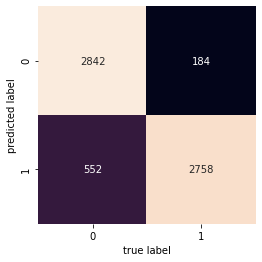

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

print(classification_report(ytest,y_pred))
mat = confusion_matrix(ytest, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            # xticklabels=faces.target_names,
            # yticklabels=faces.target_names
            )
plt.xlabel('true label')
plt.ylabel('predicted label');

In [56]:
import pickle

save_path_svm = "/Users/phunp/Documents/Flinders/Thesis/data/real_data/saved_model/model_binary_svm_88_20210925"
pickle.dump(model, open(save_path_svm, 'wb'))

# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))

In [34]:
np.logspace(-9, 9, num=4, base=10)

array([1.e-09, 1.e-03, 1.e+03, 1.e+09])

In [ ]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
std = StandardScaler()
pca = PCA(n_components=150, whiten=True)
svc = SVC(kernel='rbf')
pipe = Pipeline([('std',std),('pca', pca),('svc',svc)])

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
  'pca__n_components': [50, 100, 200],
  'svc__kernel': ['rbf',  'sigmoid', 'linear'],
  'svc__C': [0.1, 1, 10]
#   'svc__C': np.logspace(-9, 9, num=2, base=10),
#   'svc__gamma' : np.logspace(-9, 9, num=2, base=10)
}


# search = GridSearchCV(pipe, param_grid,
#                       scoring="accuracy",
#                       cv=StratifiedKFold(n_splits=2),
#                       verbose=1, )
search = GridSearchCV(pipe, param_grid,
                      scoring="accuracy",
                      cv=5,
                      verbose=2, refit=True, n_jobs=3)
%time search.fit(Xtrain, ytrain)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)


Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Pipeline(steps=[('std', StandardScaler()),
                ('pca', PCA(n_components=20, whiten=True)),
                ('svc', SVC(C=1000000000.0, gamma=1000000000.0))])
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       978
           2       0.38      1.00      0.55      2388
           3       1.00      0.01      0.01       916
           4       0.00      0.00      0.00       540
           5       0.00      0.00      0.00       844
           6       0.00      0.00      0.00         7
           7       0.00      0.00      0.00       597

    accuracy                           0.38      6270
   macro avg       0.20      0.14      0.08      6270
weighted avg       0.29      0.38      0.21      6270



/Users/phunp/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


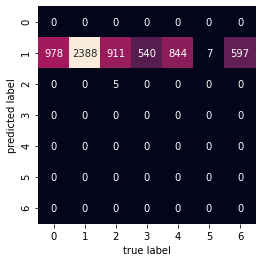

In [36]:
model_best = search.best_estimator_
yfit = model_best.predict(Xtest)
print(model_best)

from sklearn.metrics import confusion_matrix
print(classification_report(ytest,yfit))
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            ##xticklabels=faces.target_names,
            ##yticklabels=faces.target_names
            )
plt.xlabel('true label')
plt.ylabel('predicted label');

In [30]:
def calculate_bm(cm):

    TN = cm[1][1]
    FN = cm[0][1]
    TP = cm[0][0]
    FP = cm[1][0]

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)

    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    F1 = 2*(PPV*TPR)/(PPV+TPR)
    BM = TPR + TNR - 1

    return BM

predictions: [1 1 0 1 1 1 0 1 1 0]
acutal     : [1 1 0 1 1 1 0 1 0 0]

Evaluation of hidden_layer_size: 250, max_iter: 2000

              precision    recall  f1-score   support

           0       0.87      0.84      0.85      3394
           1       0.82      0.86      0.84      2942

    accuracy                           0.85      6336
   macro avg       0.85      0.85      0.85      6336
weighted avg       0.85      0.85      0.85      6336

[[2841  553]
 [ 418 2524]]
Bookmaker for Test with MLP is 0.69


/Users/phunp/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


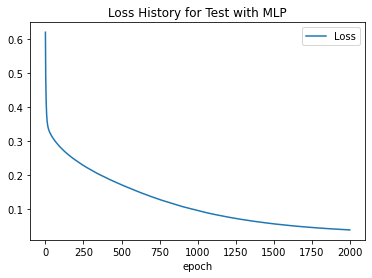

In [31]:
# Test with MLP
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from sklearn.neural_network import MLPClassifier

# X1 = X[0:400]
# y1 = y[0:400]
X1 = X
y1 = Y

# split into train and test
# Xtrain, Xtest, ytrain, ytest = train_test_split(X, y,stratify=y)
Xtrain, Xtest, ytrain, ytest = train_test_split(X1, y1,test_size=0.33, random_state=42)

# normalise features
input_std = StandardScaler()
input_std.fit(Xtrain)
Xtrain_std = input_std.transform(Xtrain)
Xtest_std = input_std.transform(Xtest)

# do the PCA, choose the numbher of components to retain
input_pca = PCA(n_components=50, whiten=True)
input_pca.fit(Xtrain_std)
Xtrain_std_pca = input_pca.transform(Xtrain_std)
Xtest_std_pca = input_pca.transform(Xtest_std)

## MLP PART
data_name = "Test with MLP"
# model initialization
hidden_layer_size = 250
max_iter = 2000
mlp = MLPClassifier(hidden_layer_sizes=(hidden_layer_size), max_iter=max_iter, alpha=0.01, #try change hidden layer, or max_iter
                    solver='sgd', verbose=0, tol=0.000001, #try verbode=0 to train with out logging
                    early_stopping=False, momentum=0.9) 

### Train the Model
# The function call to `fit` trains the model using the training data.  
h = mlp.fit(Xtrain_std_pca,ytrain)

### Plot a loss curve
# The loss curve shows the history of how the training progressed.
plt.plot(h.loss_curve_)
plt.title('Loss History for ' + data_name)
plt.xlabel('epoch')
plt.legend(['Loss'])


## Evaluate the performance of the classifier
# Let's have a look at predicting the first 10 instances in the test data set.  How did it do?  How many matches?
print('predictions: {0}'.format(mlp.predict(Xtest_std_pca[0:10,:])))
print('acutal     : {0}'.format(np.ravel(ytest)[0:10]))

# Calculate evaluation measures
print()
print('Evaluation of hidden_layer_size: {}, max_iter: {}'.format(hidden_layer_size, max_iter))
print()
y_pred = mlp.predict(Xtest_std_pca)
cm = confusion_matrix(ytest, y_pred,normalize=None)
cr = classification_report(ytest,y_pred)
print(cr)
f1 = f1_score(ytest, y_pred,average='weighted')
cm = confusion_matrix(ytest, y_pred)
bm = calculate_bm(cm)
print(cm)
print('Bookmaker for {0} is {1:.2f}'.format(data_name,bm))



# Create a confusion matrx using the function `confusion_matrix` and plot using seaborn
# df_cm = pd.DataFrame(cm, columns=['0','1'], index=['0','1'])
# fig, ax1 = plt.subplots(1,1, figsize=(10,8))
# ax = sns.heatmap(df_cm, annot=True, ax=ax1, square=True,  cmap="YlGnBu", fmt='d')
# ax.set_title('Confusion Matrix with {1} nodes, bm = {2:.2f}'.format(data_name,hidden_layer_size,bm))
# ax.set_xlabel('predicted')
# ax.set_ylabel('actual')

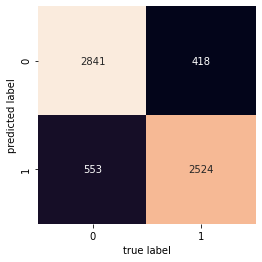

In [33]:
# Confusion matrix for mlp
mat = confusion_matrix(ytest, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            # xticklabels=faces.target_names,
            # yticklabels=faces.target_names
            )
plt.xlabel('true label')
plt.ylabel('predicted label');

In [58]:
import pickle

save_path_mlp = "/Users/phunp/Documents/Flinders/Thesis/data/real_data/saved_model/model_binary_mlp_85_20210925"
pickle.dump(mlp, open(save_path_mlp, 'wb'))

# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))

In [42]:

# print(np.max(y))
# print(np.min(y))
# print(np.array([np.where(y > 2)]))
# for name, idx in indexes.items():
#     if idx == 454:
#         print(name)
# print(indexes)

In [45]:
# Run K fold
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_blobs
from sklearn.datasets import make_circles

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing

### Split into training and testing
#
# Here we use the `train_test_split` function from the `sklearn.model_selection` module.  The parameter `test_size=0.3` specifies the percentage (30%) of the data to use as test data, `random_state=0` sets the random generator to a specific state, and `stratify=y` is important to maintain the same ratio of class distribution between the train and test splits.
#
# This is the simplest way to split the data.
#
# x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

y = Y

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=2)

foldi = 1
ac = [] # accuracy_score
cr = [] # classification_report
cm = [] # confusion_matrix

for train_split, test_split in kf.split(X, y):
    # print("train {} and test {}".format(train_split, test_split))
    x_train = X[train_split]
    y_train = y[train_split]

    x_test = X[test_split]
    y_test = y[test_split]

    # converting to float 32bit
    # x_train = np.array(x_train).astype(np.float32)
    # x_test  = np.array(x_test).astype(np.float32)
    # y_train = np.array(y_train).astype(np.float32)
    # y_test  = np.array(y_test).astype(np.float32)

    # print data split for validation
    print(x_train.shape, y_train.shape)
    print(x_test.shape, y_test.shape)

    # calculate transformation values on the *train* data
    scaler = preprocessing.StandardScaler().fit(x_train)

    # apply to both the train and test - no leakage
    do_normalize = True # change this to True or False to see the affect of normalization
    # if (do_normalize):
    #   x_train_scaled = scaler.transform(x_train)
    #   x_test_scaled  = scaler.transform(x_test)
    # else:
    #   x_train_scaled = x_train 
    #   x_test_scaled  = x_test

    # #converting to float 32bit
    # x_train_scaled = np.array(x_train_scaled).astype(np.float32)
    # x_test_scaled  = np.array(x_test_scaled).astype(np.float32)
    # y_train = np.array(y_train).astype(np.float32)
    # y_test  = np.array(y_test).astype(np.float32)
    if (do_normalize):
        # normalise features
        input_std = StandardScaler()
        input_std.fit(Xtrain)
        x_train_scaled = input_std.transform(x_train)
        x_test_scaled = input_std.transform(x_test)

    # do the PCA, choose the numbher of components to retain
    input_pca = PCA(n_components=50, whiten=True)
    input_pca.fit(x_train_scaled)
    x_train_scaled = input_pca.transform(x_train_scaled)
    x_test_scaled = input_pca.transform(x_test_scaled)

    ### Set up the model
    #
    # Setting up the model is where we can change settings and evaluate the affect on performance.  You can change settings such as
    # - `hidden_layer_sizes`: fewer nodes means less to optimize and quicker training, but too few nodes cannot model more complex problems.  How does it go with 1, 2, 3, 5, 10, more?
    # - `max_iter`: the number of iterations to train for.  Too many will take too long, but too few and the MLP may stop before it converges.  What's the smallest max_iter to get 'good' performance?
    #
    # Have a look at the [documentation for the MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) to see what the different parameters do to the learning.

    # model initialization
    hidden_layer_size = 20
    max_iter = 2000
    mlp = MLPClassifier(hidden_layer_sizes=(hidden_layer_size), max_iter=max_iter, alpha=0.01, #try change hidden layer, or max_iter
                    solver='lbfgs', verbose=0, tol=0.000001, #try verbode=0 to train with out logging
                    early_stopping=False, momentum=0.9, 
                    learning_rate='constant', max_fun=15000) 

    ### Train the Model
    # The function call to `fit` trains the model using the training data.  
    h = mlp.fit(x_train_scaled,y_train)

    print('training score  : {:.2f}'.format(h.score(x_train_scaled,y_train)))
    if (h.early_stopping): 
        print('validation score: {:.2f}'.format(h.best_validation_score_))

    # evaluate the model
    # y_prob = mlp.predict_proba(x_test_scaled)
    y_prob = mlp.predict(x_test_scaled)
    y_pred = y_prob
    print(y_prob)
    # y_pred = (y_pred == y_pred.max(axis=1)[:,None]).astype(int)
    print('--- min {} and max {}'.format(np.min(y_pred), np.max(y_pred)))

    # y_test_max = y_test.argmax(axis=1).astype(int)
    # y_test_max = y_test
    # print('y_test {} -> y_test_max {}'.format(y_test, y_test_max))
    # y_pred_max = y_pred.argmax(axis=1).astype(int)
    # print('--- content of y_test_max: {0}, y_pred_max: {1}'.format(y_test_max, y_pred_max))

    ac.append(accuracy_score(y_test,y_pred))
    print('accuracy is {:.2f}%'.format(ac[-1]*100)) # Print accuracy score
    print()
    cr.append(classification_report(y_test,y_pred)) # Print summary report
    print('shape of current confusion_matrix of current fold {0} is {1}'.format(foldi, confusion_matrix(y_test, y_pred)))
    cm.append(confusion_matrix(y_test, y_pred))

    foldi = foldi + 1

    ### Plot a loss curve
    # The loss curve shows the history of how the training progressed.
    # plt.plot(h.loss_curve_)
    # plt.title('Loss History for ' + data_name)
    # plt.xlabel('epoch')
    # plt.legend(['Loss'])


    ## Evaluate the performance of the classifier
    # Let's have a look at predicting the first 10 instances in the test data set.  How did it do?  How many matches?
    # print('predictions: {0}'.format(mlp.predict(x_test[0:10,:])))
    # print('acutal     : {0}'.format(np.ravel(y_test)[0:10]))

    # # Calculate evaluation measures
    # print()
    # print('Evaluation of hidden_layer_size: {}, max_iter: {}'.format(hidden_layer_size, max_iter))
    # print()
    # y_pred = mlp.predict(x_test)
    # cm = confusion_matrix(y_test, y_pred,normalize=None)
    # cms.append(cm)
    # cr = classification_report(y_test,y_pred)
    # crs.append(cr)
    # print(cr)
    # f1 = f1_score(y_test, y_pred,average='weighted')
    # f1s.append(f1)
    # cm = confusion_matrix(y_test, y_pred)
    # bm = calculate_bm(cm)
    # bms.append(bm)
    # print(cm)
    # print('Bookmaker for {0} is {1:.2f}'.format(data_name,bm))

    # # Create a confusion matrx using the function `confusion_matrix` and plot using seaborn
    # df_cm = pd.DataFrame(cm, columns=['0','1'], index=['0','1'])
    # fig, ax1 = plt.subplots(1,1, figsize=(10,8))
    # ax = sns.heatmap(df_cm, annot=True, ax=ax1, square=True,  cmap="YlGnBu", fmt='d')
    # ax.set_title('Confusion Matrix with {1} nodes, bm = {2:.2f}'.format(data_name,hidden_layer_size,bm))
    # ax.set_xlabel('predicted')
    # ax.set_ylabel('actual')


####### evaluated from Evaluating Machine Learning
print('Average Accuracy: {0}% +/- {1}% SD'.format(np.round(np.mean(ac)*100,2),np.round(np.std(ac)*100,2)))

def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
    
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()

def precision_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_precisions = 0
    for label in range(rows):
        sum_of_precisions += precision(label, confusion_matrix)
    return sum_of_precisions / rows

def recall_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_recalls = 0
    for label in range(columns):
        sum_of_recalls += recall(label, confusion_matrix)
    return sum_of_recalls / columns

def f1score(confusion_matrix):
    precision = precision_macro_average(confusion_matrix)
    recall = recall_macro_average(confusion_matrix)
    return (2 * recall * precision) / (recall + precision)


# print('shape cm {0}'.format(np.shape(cm)))
# print('shapeeeee {0}'.format(np.shape(np.stack(cm,axis=2))))

print(cm)
cm_all = np.sum(np.stack(cm,axis=2),axis=2)
print(cm_all) # ACC, PPV, TPR, F1, BM

acc_a, prec_a, recall_a, f1_a, bm_a = calculate_bm(cm_all)
print('-- Overall Accuracy      : {0}'.format(np.round(acc_a*100,2)))
print('-- Overall Precision     : {0}'.format(np.round(prec_a,2)))
print('-- Overall Recall        : {0}'.format(np.round(recall_a,2)))
print('-- Overall F1-score      : {0}'.format(np.round(f1_a,2)))
print('-- Overall Bookmaker     : {0}'.format(np.round(bm_a,2)))

print('Old way to calculate: ')
acc_all = np.sum(np.diag(cm_all)) / np.sum(cm_all,axis=(0, 1))
print('Overall Accuracy       : {0}%'.format(np.round(acc_all*100,2)))

print('Overall Macro Precision: {0}%'.format(np.round(precision_macro_average(cm_all)*100,2)))
print('Overall Macro Recall   : {0}%'.format(np.round(recall_macro_average(cm_all)*100,2)))
print('Overall F1-Score       : {0}'.format(np.round(f1score(cm_all),2)))

# for i, label in enumerate(class_labels):
#   print('{0}\t precision: {1}%, recall: {2}%, f1: {3}'.format(label,np.round(precision(i,cm_all)*100,0),np.round(recall(i,cm_all)*100,0),np.round(f1score(cm_all),2)))

#df_cm = pd.DataFrame((cm_all/np.sum(cm_all,axis=1)*100), columns=class_labels, index=class_labels)
df_cm = pd.DataFrame(cm_all, columns=class_labels, index=class_labels)
fig, ax1 = plt.subplots(1,1, figsize=(10,10))
sns.heatmap(df_cm, annot=True, ax=ax1,square=True,  cmap="YlGnBu",vmin=0,vmax=500)




(17100, 61440) (17100,)
(1900, 61440) (1900,)


/Users/phunp/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


training score  : 0.20
[5 2 4 ... 4 5 7]
--- min 0 and max 7
accuracy is 13.95%

shape of current confusion_matrix of current fold 1 is [[13 23 33 24 30 30 29 20]
 [10 27 37 23 39 21 48 22]
 [ 7 43 37 18 34 43 39 26]
 [15 39 37 34 34 30 38 28]
 [16 32 39 18 50 41 47 20]
 [ 6 26 33 22 64 38 50 23]
 [12 38 31 17 46 35 50 22]
 [ 9 23 17 23 31 33 41 16]]
(17100, 61440) (17100,)
(1900, 61440) (1900,)


/Users/phunp/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


training score  : 0.19
[4 4 7 ... 0 2 6]
--- min 0 and max 7
accuracy is 11.89%

shape of current confusion_matrix of current fold 2 is [[11 26 29 17 42 18 41 18]
 [18 24 35 19 47 21 38 25]
 [14 21 29 27 57 30 37 32]
 [20 25 31 24 62 29 47 17]
 [17 33 17 39 53 38 39 27]
 [ 9 38 19 27 61 31 47 31]
 [ 9 33 23 22 65 37 34 28]
 [14 21 19 15 37 28 38 20]]
(17100, 61440) (17100,)
(1900, 61440) (1900,)


/Users/phunp/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


training score  : 0.20
[0 3 5 ... 3 4 2]
--- min 0 and max 7
accuracy is 12.84%

shape of current confusion_matrix of current fold 3 is [[29 21 24 41 17 18 34 18]
 [31 17 18 38 24 45 38 16]
 [27 21 30 41 38 37 30 23]
 [21 27 28 45 35 40 42 17]
 [32 17 27 63 31 34 35 24]
 [17 25 28 57 33 32 41 30]
 [29 20 32 46 30 34 41 19]
 [19 12 24 44 26 27 21 19]]
(17100, 61440) (17100,)
(1900, 61440) (1900,)


/Users/phunp/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


training score  : 0.20
[4 6 7 ... 6 5 6]
--- min 0 and max 7
accuracy is 13.00%

shape of current confusion_matrix of current fold 4 is [[17 28 23 16 36 35 33 14]
 [31 20 27 32 29 43 34 12]
 [27 28 26 32 32 48 33 21]
 [25 20 30 40 39 45 38 18]
 [22 15 39 39 39 48 33 28]
 [31 21 25 27 33 58 49 19]
 [23 15 30 38 40 50 30 24]
 [10 20 24 24 21 48 28 17]]
(17100, 61440) (17100,)
(1900, 61440) (1900,)


/Users/phunp/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


training score  : 0.19
[2 4 0 ... 4 7 4]
--- min 0 and max 7
accuracy is 12.05%

shape of current confusion_matrix of current fold 5 is [[24 20 27 24 29 32 23 22]
 [22 20 29 26 39 43 29 20]
 [26 33 29 20 43 39 28 29]
 [28 17 49 14 47 40 32 28]
 [24 23 35 23 43 34 45 36]
 [33 19 40 21 44 42 35 29]
 [20 25 24 24 42 42 33 41]
 [15 17 25 13 31 35 32 24]]
(17100, 61440) (17100,)
(1900, 61440) (1900,)
training score  : 0.19
[3 7 4 ... 6 0 1]
--- min 0 and max 7
accuracy is 12.32%

shape of current confusion_matrix of current fold 6 is [[28 11 29 46 30 17 13 28]
 [26  9 32 39 50 21 21 30]
 [28 12 28 35 50 32 22 39]
 [36 11 26 34 58 27 39 24]
 [27 12 41 44 50 38 27 24]
 [27 13 34 44 52 33 28 32]
 [20 20 33 29 53 26 33 37]
 [24 15 28 24 32 22 28 19]]
(17100, 61440) (17100,)
(1900, 61440) (1900,)


/Users/phunp/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


training score  : 0.20
[3 2 4 ... 6 2 0]
--- min 0 and max 7
accuracy is 11.89%

shape of current confusion_matrix of current fold 7 is [[24 25 42 14 52 17 26  2]
 [24 22 40 13 61 22 39  7]
 [30 29 47 14 60 28 26 13]
 [27 21 57 17 56 28 42  7]
 [30 24 50 19 57 25 40 18]
 [31 21 57 20 69 16 37 11]
 [32 24 40 18 58 34 35 10]
 [21 16 36 14 38 29 30  8]]
(17100, 61440) (17100,)
(1900, 61440) (1900,)


/Users/phunp/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


training score  : 0.19
[5 3 0 ... 2 5 1]
--- min 0 and max 7
accuracy is 12.63%

shape of current confusion_matrix of current fold 8 is [[24 26 22 41 25 26 30  8]
 [37 14 21 43 15 41 41 16]
 [25 21 32 52 18 48 42  9]
 [25 20 35 48 19 51 41 16]
 [24 19 41 66 24 41 38 10]
 [34 14 37 48 29 43 42 15]
 [23 14 36 43 23 53 48 11]
 [24 13 28 31 13 40 36  7]]
(17100, 61440) (17100,)
(1900, 61440) (1900,)


/Users/phunp/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


training score  : 0.20
[5 7 2 ... 7 0 7]
--- min 0 and max 7
accuracy is 12.11%

shape of current confusion_matrix of current fold 9 is [[27 27 28 10 47 28 11 24]
 [25 26 27 16 56 38 12 28]
 [31 26 23 18 56 36 14 43]
 [33 29 18 22 56 51 16 30]
 [27 32 33 21 51 48 18 33]
 [29 24 31 16 63 41 17 41]
 [28 21 31 16 57 43 12 43]
 [32 18 20 10 33 35 16 28]]
(17100, 61440) (17100,)
(1900, 61440) (1900,)


/Users/phunp/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


training score  : 0.20
[2 0 2 ... 6 5 2]
--- min 0 and max 7
accuracy is 12.42%

shape of current confusion_matrix of current fold 10 is [[32 16 37 19 24 28 27 19]
 [33 15 44 27 28 34 32 14]
 [41 14 39 43 31 37 30 12]
 [31 17 38 40 40 46 30 14]
 [35 17 41 45 27 40 42 16]
 [40 12 45 38 38 29 34 26]
 [28 16 38 40 33 39 42 15]
 [26 12 24 18 32 36 32 12]]
Average Accuracy: 12.51% +/- 0.6% SD
[array([[13, 23, 33, 24, 30, 30, 29, 20],
       [10, 27, 37, 23, 39, 21, 48, 22],
       [ 7, 43, 37, 18, 34, 43, 39, 26],
       [15, 39, 37, 34, 34, 30, 38, 28],
       [16, 32, 39, 18, 50, 41, 47, 20],
       [ 6, 26, 33, 22, 64, 38, 50, 23],
       [12, 38, 31, 17, 46, 35, 50, 22],
       [ 9, 23, 17, 23, 31, 33, 41, 16]]), array([[11, 26, 29, 17, 42, 18, 41, 18],
       [18, 24, 35, 19, 47, 21, 38, 25],
       [14, 21, 29, 27, 57, 30, 37, 32],
       [20, 25, 31, 24, 62, 29, 47, 17],
       [17, 33, 17, 39, 53, 38, 39, 27],
       [ 9, 38, 19, 27, 61, 31, 47, 31],
       [ 9, 33, 23, 22, 65, 37, 

TypeError: cannot unpack non-iterable numpy.float64 object

In [46]:
# Test with Keras
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, MaxPooling2D, Conv2D
from tensorflow.keras import optimizers

def build_simple_model(X, y, activation='relu'):

    number_of_features = len(X[0])
    number_hidden_nodes = 512;
    number_of_output = len(y[0])
    print('Number of input features: {}'.format(number_of_features))
    print('Number of hidden nodes: {}'.format(number_hidden_nodes))
    print('Activation Function on hidden layer: {}'.format(activation))
    print('Number of out classes: {}'.format(number_of_output))

    model = keras.Sequential([
        Dense(number_hidden_nodes, activation=activation, input_shape=[number_of_features]),
        Dense(number_hidden_nodes/2, activation=activation, input_shape=[number_of_features]),
        # Conv2D(32, 3, activation="relu"),
        # MaxPooling2D(3),
        Dense(number_of_output, activation=tf.nn.sigmoid)
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=keras.losses.categorical_crossentropy,
                  metrics=[keras.metrics.categorical_crossentropy])
    model.summary()
    return model


/Users/phunp/opt/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/phunp/opt/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/phunp/opt/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/phunp/opt/anaconda3/envs/py37/lib

In [69]:
from sklearn.preprocessing import OneHotEncoder
y = Y
#update y to one hot encode
onehot_encoder = OneHotEncoder(sparse=False)
y_encoded = y.reshape(len(y), 1)
y1h = onehot_encoder.fit_transform(y_encoded)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y1h,test_size=0.33, random_state=42)
# normalise features
input_std = StandardScaler()
input_std.fit(Xtrain)
Xtrain_std = input_std.transform(Xtrain)
Xtest_std = input_std.transform(Xtest)

# do the PCA, choose the numbher of components to retain
input_pca = PCA(n_components=50, whiten=True)
input_pca.fit(Xtrain_std)
Xtrain_std_pca = input_pca.transform(Xtrain_std)
Xtest_std_pca = input_pca.transform(Xtest_std)


no_epochs = 50
activation = 'relu' # select from [None, 'sigmoid', 'tanh', 'relu']:
model = build_simple_model(Xtrain_std_pca, ytrain, activation=activation) 


print('Training with {0} for {1} epochs'.format(activation, no_epochs))
history = model.fit(Xtrain_std_pca, ytrain, epochs=no_epochs, verbose=1)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch


loss_final = np.sqrt(float(hist['loss'].tail(1)))
print()
print('Final Loss on training set: {}'.format(round(loss_final, 3)))

ValueError: Found array with dim 4. StandardScaler expected <= 2.

In [38]:
from keras.utils import to_categorical
from keras import backend as K
from keras.layers import Dense, Dropout,Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers.core import Activation
from keras.optimizers import SGD

def build_cnn_model(X, y):
    # construct model
    number_of_features = len(X[0])
    shape = (160,160,3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3,3), padding = 'same',activation = 'relu', input_shape = shape))
    model.add(MaxPooling2D((2,2)))

    model.add(Conv2D(64, kernel_size = (3,3), padding = 'same', activation = 'relu'))
    model.add(MaxPooling2D(2,2))

    model.add(Conv2D(128, kernel_size = (3,3), padding = 'same', activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(64,activation = 'relu'))
    model.add(Dense(16,activation = 'relu'))
    model.add(Dense(2,activation = 'softmax')) # softmax. linear

    opt = SGD(lr=0.001)
#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
#     model.summary()

    return model

    # train model
#     h=model.fit(train, labels, validation_split = 0.2, epochs = 10, batch_size = 64)

    # save model to file
    # model.save("./saved-model/mnist_data_model")

In [39]:
print(Y.shape)
print(np.unique(Y))
y = Y
y = to_categorical(y)
print(y.shape)

(19200,)
[0 1]
(19200, 2)


In [41]:
from sklearn.preprocessing import OneHotEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

y = Y
XX = X/255
XX = XX.reshape((IMAGE_COUNT,160,160,3))
# XX = XX / 255
#update y to one hot encode
# onehot_encoder = OneHotEncoder(sparse=False)
# y_encoded = y.reshape(len(y), 1)
# y1h = onehot_encoder.fit_transform(y_encoded)
y = to_categorical(y)

Xtrain, Xtest, ytrain, ytest = train_test_split(XX, y,test_size=0.33, random_state=42, stratify=y)
# # normalise features
# input_std = StandardScaler()
# input_std.fit(Xtrain)
# Xtrain_std = input_std.transform(Xtrain)
# Xtest_std = input_std.transform(Xtest)

# # do the PCA, choose the numbher of components to retain
# input_pca = PCA(n_components=50, whiten=True)
# input_pca.fit(Xtrain_std)
# Xtrain_std_pca = input_pca.transform(Xtrain_std)
# Xtest_std_pca = input_pca.transform(Xtest_std)


no_epochs = 30
activation = 'sigmoid' # select from [None, 'sigmoid', 'tanh', 'relu']:
model_cnn = build_cnn_model(Xtrain, ytrain) 


print('Training with {0} for {1} epochs'.format(activation, no_epochs))
history = model_cnn.fit(Xtrain, ytrain, validation_split = 0.2, epochs=no_epochs, verbose=1)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch


loss_final = np.sqrt(float(hist['loss'].tail(1)))
print()
print('Final Loss on training set: {}'.format(round(loss_final, 3)))

Training with sigmoid for 30 epochs
Train on 10291 samples, validate on 2573 samples
Epoch 1/30
10291/10291 [==============================] - 192s 19ms/step - loss: 0.6231 - accuracy: 0.8193 - val_loss: 0.5909 - val_accuracy: 0.8500
Epoch 2/30
10291/10291 [==============================] - 165s 16ms/step - loss: 0.5768 - accuracy: 0.8430 - val_loss: 0.5479 - val_accuracy: 0.8500
Epoch 3/30
10291/10291 [==============================] - 156s 15ms/step - loss: 0.5068 - accuracy: 0.8430 - val_loss: 0.4438 - val_accuracy: 0.8500
Epoch 4/30
10291/10291 [==============================] - 156s 15ms/step - loss: 0.4058 - accuracy: 0.8426 - val_loss: 0.3729 - val_accuracy: 0.8480
Epoch 5/30
10291/10291 [==============================] - 157s 15ms/step - loss: 0.3684 - accuracy: 0.8420 - val_loss: 0.3544 - val_accuracy: 0.8500
Epoch 6/30
10291/10291 [==============================] - 154s 15ms/step - loss: 0.3566 - accuracy: 0.8419 - val_loss: 0.3470 - val_accuracy: 0.8500
Epoch 7/30
10291/1029

(19200, 76800)
(19200, 2)
19.0
(160, 160, 3)


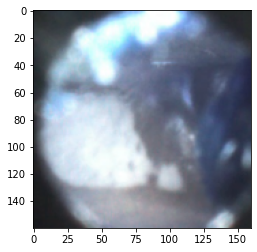

In [47]:
%matplotlib inline 
from matplotlib import pyplot as plt # this lets you draw inline pictures in the notebooks

print(X.shape)
print(y.shape)

print(np.min(X[2000]))
testOne = X[1005]/255
testOne = testOne.reshape(160, 160, 3)
# testOne = cv2.cvtColor(testOne, cv2.COLOR_BGR2RGB)
print(testOne.shape)

plt.imshow(testOne)



In [48]:
hist

,val_loss,val_accuracy,loss,accuracy,epoch
0,0.590871,0.849981,0.623058,0.819260,0
1,0.547866,0.849981,0.576781,0.842970,1
2,0.443801,0.849981,0.506815,0.842970,2
3,0.372942,0.848037,0.405796,0.842581,3
4,0.354437,0.849981,0.368386,0.841998,4
5,0.346975,0.849981,0.356625,0.841901,5
6,0.343595,0.849981,0.352691,0.842095,6
7,0.341431,0.849981,0.349087,0.842775,7
8,0.344472,0.848037,0.346381,0.842775,8
9,0.354677,0.844151,0.344550,0.842192,9


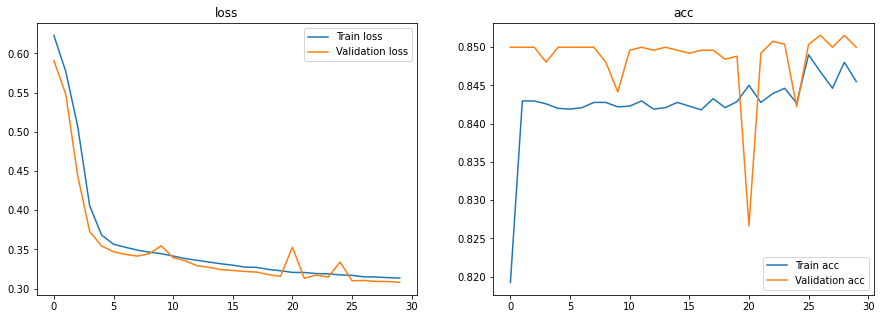

In [49]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

show_final_history(history)

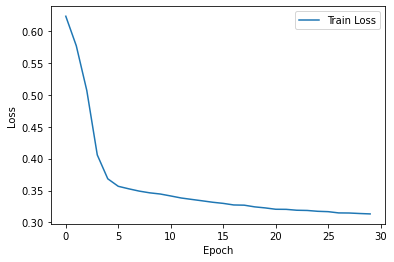

In [50]:
def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'], label='Train Loss')
    plt.legend()

plot_history()

In [51]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

[loss, crossent] = model_cnn.evaluate(Xtest, ytest)
print('Loss on test set: {}'.format(round(loss, 3)))
y_pred_real = model_cnn.predict(Xtest)
y_pred = np.argmax(y_pred_real, axis=-1)


ytest_for_report = np.argmax(ytest, axis=-1)
cr = classification_report(ytest_for_report,y_pred)
print(cr)
f1 = f1_score(ytest_for_report, y_pred,average='weighted')
cm = confusion_matrix(ytest_for_report, y_pred)
print(cm)

6336/6336 [==============================] - 44s 7ms/step
Loss on test set: 0.317
              precision    recall  f1-score   support

           0       0.97      0.72      0.83      3407
           1       0.75      0.97      0.85      2929

    accuracy                           0.84      6336
   macro avg       0.86      0.85      0.84      6336
weighted avg       0.87      0.84      0.84      6336

[[2466  941]
 [  76 2853]]


Text(0.5, 1.0, 'Overall f1-score: 0.838')

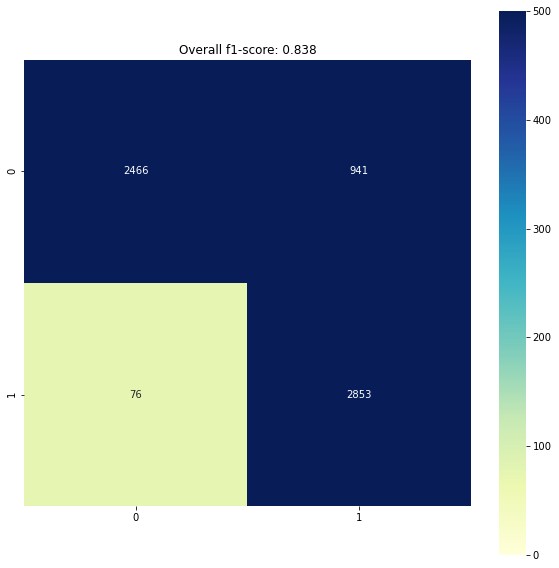

In [52]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

import seaborn as sns

class_labels = np.unique(ytest_for_report);
df_cm = pd.DataFrame(cm, columns=class_labels, index=class_labels)
fig, ax1 = plt.subplots(1,1, figsize=(10,10))
sns.heatmap(df_cm, annot=True, ax=ax1,square=True,  cmap="YlGnBu",vmin=0,vmax=500,fmt='d')
ax1.set_title('Overall f1-score: {:.3f}'.format(f1) )

              precision    recall  f1-score   support

           0       0.97      0.72      0.83      3407
           1       0.75      0.97      0.85      2929

    accuracy                           0.84      6336
   macro avg       0.86      0.85      0.84      6336
weighted avg       0.87      0.84      0.84      6336



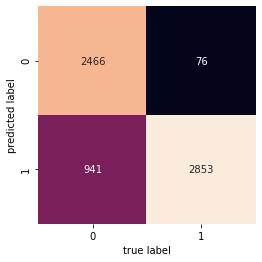

In [53]:
from sklearn.metrics import confusion_matrix
print(classification_report(ytest_for_report,y_pred))
mat = confusion_matrix(ytest_for_report, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            ##xticklabels=faces.target_names,
            ##yticklabels=faces.target_names
            )
plt.xlabel('true label')
plt.ylabel('predicted label');

In [55]:
# save model to file
save_path = "/Users/phunp/Documents/Flinders/Thesis/data/real_data/saved_model/model_binary_cnn_84_20210925"
model_cnn.save(save_path)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import optimizers
from keras.optimizers import Adam


# X shape:  (454, 228, 200, 3)


def build_MobileNetV2_adapt():
    # set the shape to the CIFAR-10 image size and the number of classes
    input_shape = (228, 200, 3)
    # resize image with padding give better results on the overall performance
    # new_shape = (96, 96, 3)
    classes = 3

    # Create new model on top
    inputs = keras.Input(shape=input_shape)

    # Preprocessing the image
    # x = preprocess_input(inputs)
    # upscale = keras.layers.Lambda(lambda x: tf.image.resize_with_pad(
    #     x, 96, 96, method=tf.image.ResizeMethod.BILINEAR))(inputs)
                                                                  
    # load the VGG16 model with the imagenet weights, but without the final 1000 output layer
    base_model = keras.applications.MobileNetV2(
        weights="imagenet",  # Load weights pre-trained on ImageNet.
        input_shape=input_shape, # input_tensor will be used instead
        input_tensor=inputs,
        include_top=False,
    )  # Do not include the ImageNet classifier at the top.
    # The base model contains batchnorm layers. We want to keep them in inference mode
    # when we unfreeze the base model for fine-tuning, so we make sure that the
    # base_model is running in inference mode here.
    x = base_model.output#, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    # add a trainable dense layer
    x = keras.layers.Dense(256, activation='relu')(x)
    x = keras.layers.Dropout(0.25)(x)  # Regularize with dropout
    # add a final output layer with a softmax for classification
    outputs = keras.layers.Dense(classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)

    # make model adaptable
    base_model.trainable = False

    # small learning rate
    # learning_rate = 1e-5

    model.compile(
        optimizer='Adam', #learning_rate=learning_rate
        loss='categorical_crossentropy',
        metrics=['categorical_crossentropy']
    )
    return model

In [ ]:
print(X.shape)
print(y.shape)

(454, 228, 200, 3)
(454,)


In [ ]:
from keras.optimizers import Adam
model = build_MobileNetV2_adapt()
# model.compile(optimizer=Adam(),
#               loss='categorical_crossentropy',
#               metrics=['categorical_accuracy'])

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 228, 200, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 114, 100, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 114, 100, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 114, 100, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [ ]:
# Test with MLP
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder

X1 = X[0:400]
y1 = y[0:400]

onehot_encoder = OneHotEncoder(sparse=False)
y_encoded = y1.reshape(len(y1), 1)
y1h = onehot_encoder.fit_transform(y_encoded)

Xtrain, Xtest, ytrain, ytest = train_test_split(X1, y1h,test_size=0.33, random_state=42)

# split into train and test
# Xtrain, Xtest, ytrain, ytest = train_test_split(X, y,stratify=y)
# Xtrain, Xtest, ytrain, ytest = train_test_split(X1, y1,test_size=0.33, random_state=42)
model.fit(Xtrain,ytrain)



9/9 [==============================] - 30s 41ms/step - loss: 1.4277 - categorical_crossentropy: 1.4277


In [ ]:
### Plot confusion matrix
from matplotlib import pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm):
    df_cm = pd.DataFrame(cm, columns=class_labels, index=class_labels)
    fig, ax1 = plt.subplots(1,1, figsize=(10,10))
    sns.heatmap(df_cm, annot=True, ax=ax1,square=True,  cmap="YlGnBu",fmt='d')
    ax1.set_title('Overall f1-score: {:.3f}'.format(f1score(cm)) );
    plt.xlabel('true label')
    plt.ylabel('predicted label');

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

y_pred_real = model.predict(Xtest)
y_pred_max = np.argmax(y_pred_real, axis=-1).astype(int)

y_test_max = ytest.argmax(axis=1).astype(int)

print(y_pred_max)
print(y_test_max)

ac = accuracy_score(y_test_max,y_pred_max)
print('accuracy is {:.2f}%'.format(ac*100)) # Print accuracy score
print()
cr = classification_report(y_test_max,y_pred_max) # Print summary report
print(cr)
cm = confusion_matrix(y_test_max, y_pred_max)
print(cm)
# plot_confusion_matrix(cm)

[1 0 0 1 1 0 0 1 1 1 1 1 1 1 0 0 1 1 0 1 0 1 1 1 2 1 1 1 2 1 1 1 0 0 0 1 0
 1 0 1 0 1 0 1 1 1 1 1 1 0 0 0 0 1 1 0 2 1 1 0 2 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 0 0 0 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 2 1 1 2 1 0 0 1 1 0
 1 1 1 0 2 1 1 0 1 1 1 1 1 0 0 1 0 1 1 1 1]
[2 0 0 1 0 0 0 1 2 0 1 1 1 1 0 1 2 0 0 0 0 0 2 2 2 1 2 1 2 1 1 2 0 0 0 1 0
 1 0 0 0 1 0 1 1 0 1 2 2 0 1 0 0 1 0 0 2 1 0 0 2 0 1 1 1 0 1 2 1 1 0 0 1 1
 1 0 2 1 2 0 0 1 1 1 1 2 2 1 1 0 0 1 1 1 0 1 1 1 0 2 0 1 1 0 2 0 1 0 1 2 0
 1 1 0 0 2 2 1 1 1 1 1 2 0 2 0 1 0 2 2 1 2]
accuracy is 62.88%

              precision    recall  f1-score   support

           0       0.79      0.61      0.69        49
           1       0.54      0.85      0.66        55
           2       0.86      0.21      0.34        28

    accuracy                           0.63       132
   macro avg       0.73      0.56      0.56       132
weighted avg       0.70      0.63      0.60       132

[[30 19  0]
 [ 7 47  1]
 [ 1 21  6]]
